In [1]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing

In [2]:
# Read in raw data files
df_train = pd.read_csv('./datasets/credit_train.csv')
df_test = pd.read_csv('./datasets/credit_test.csv')

In [3]:
# Concatenate raw data files into one dataframe
df = pd.concat([df_train, df_test])

In [4]:
# Remove rows which are completely null from dataframe
df = df[df.isnull().sum(axis=1) < df.shape[1]]

In [5]:
# Drop rows with contaminated credit score (invalid credit score value)
df = df[df['Credit Score'] <= 850]
df = df.reset_index(drop=True)

In [6]:
# Preview dataframe
df

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,14dd8831-6af5-400b-83ec-68e61888a048,981165ec-3274-42f5-a3b4-d104041a9ca9,Fully Paid,445412.0,Short Term,709.0,1167493.0,8 years,Home Mortgage,Home Improvements,5214.74,17.2,NaN,6.0,1.0,228190.0,416746.0,1.0,0.0
1,4eed4e6a-aa2f-4c91-8651-ce984ee8fb26,5efb2b2b-bf11-4dfd-a572-3761a2694725,Fully Paid,99999999.0,Short Term,741.0,2231892.0,8 years,Own Home,Debt Consolidation,29200.53,14.9,29.0,18.0,1.0,297996.0,750090.0,0.0,0.0
2,77598f7b-32e7-4e3b-a6e5-06ba0d98fe8a,e777faab-98ae-45af-9a86-7ce5b33b1011,Fully Paid,347666.0,Long Term,721.0,806949.0,3 years,Own Home,Debt Consolidation,8741.90,12.0,NaN,9.0,0.0,256329.0,386958.0,0.0,0.0
3,273581de-85d8-4332-81a5-19b04ce68666,90a75dde-34d5-419c-90dc-1e58b04b3e35,Fully Paid,217646.0,Short Term,730.0,1184194.0,< 1 year,Home Mortgage,Debt Consolidation,10855.08,19.6,10.0,13.0,1.0,122170.0,272052.0,1.0,0.0
4,8af915d9-9e91-44a0-b5a2-564a45c12089,af534dea-d27e-4fd6-9de8-efaa52a78ec0,Fully Paid,548746.0,Short Term,678.0,2559110.0,2 years,Rent,Debt Consolidation,18660.28,22.6,33.0,4.0,0.0,437171.0,555038.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83856,a2701102-3cb0-46a6-8658-e6f20d950182,6dc5fa63-93f4-43a9-8192-2df57548287b,NaN,442596.0,Short Term,739.0,1528968.0,7 years,Home Mortgage,Debt Consolidation,19494.38,16.7,79.0,11.0,0.0,419235.0,656876.0,0.0,0.0
83857,c4ab66f9-833c-43b8-879c-4f8bcb64dd14,8ee2002b-8fb6-4af0-ab74-25a1c23e7647,NaN,157806.0,Short Term,731.0,1514376.0,6 years,Rent,Debt Consolidation,4795.41,12.5,NaN,9.0,0.0,87058.0,234410.0,0.0,0.0
83858,bbd3a392-01b4-4e0e-9c28-b2a4a39beac7,6c306306-f5c2-4db5-b74a-af2895123ecb,NaN,132550.0,Short Term,718.0,763192.0,4 years,Home Mortgage,Debt Consolidation,12401.87,9.9,20.0,8.0,0.0,74309.0,329692.0,0.0,0.0
83859,0cc8e0e0-1bc6-49d7-ad0f-0598b647458f,f90cf410-a34b-49e7-8af9-2b405e17b827,NaN,99999999.0,Short Term,721.0,972097.0,10+ years,Home Mortgage,Debt Consolidation,12232.20,16.8,24.0,8.0,1.0,184984.0,240658.0,0.0,0.0


In [7]:
# Preview dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83861 entries, 0 to 83860
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Loan ID                       83861 non-null  object 
 1   Customer ID                   83861 non-null  object 
 2   Loan Status                   76295 non-null  object 
 3   Current Loan Amount           83861 non-null  float64
 4   Term                          83861 non-null  object 
 5   Credit Score                  83861 non-null  float64
 6   Annual Income                 83861 non-null  float64
 7   Years in current job          80371 non-null  object 
 8   Home Ownership                83861 non-null  object 
 9   Purpose                       83861 non-null  object 
 10  Monthly Debt                  83861 non-null  float64
 11  Years of Credit History       83861 non-null  float64
 12  Months since last delinquent  39647 non-null  float64
 13  N

In [8]:
# See how many missing values per column
df.isna().sum()

Loan ID                             0
Customer ID                         0
Loan Status                      7566
Current Loan Amount                 0
Term                                0
Credit Score                        0
Annual Income                       0
Years in current job             3490
Home Ownership                      0
Purpose                             0
Monthly Debt                        0
Years of Credit History             0
Months since last delinquent    44214
Number of Open Accounts             0
Number of Credit Problems           0
Current Credit Balance              0
Maximum Open Credit                 0
Bankruptcies                      171
Tax Liens                           7
dtype: int64

In [9]:
# Impute missing values for numerical data with the mean
numeric = df.select_dtypes('number')
df[numeric.columns] = numeric.fillna(numeric.mean())

In [10]:
# Impute missing values for categorical data with the mode
categoric = df.select_dtypes('object')
df[categoric.columns] = categoric.fillna(categoric.agg(lambda x: x.mode().values[0]))

In [11]:
# Confirm all missing values have been filled in
df.isna().sum()

Loan ID                         0
Customer ID                     0
Loan Status                     0
Current Loan Amount             0
Term                            0
Credit Score                    0
Annual Income                   0
Years in current job            0
Home Ownership                  0
Purpose                         0
Monthly Debt                    0
Years of Credit History         0
Months since last delinquent    0
Number of Open Accounts         0
Number of Credit Problems       0
Current Credit Balance          0
Maximum Open Credit             0
Bankruptcies                    0
Tax Liens                       0
dtype: int64

In [12]:
# Check unique values for each column
df.nunique()

Loan ID                         67340
Customer ID                     67340
Loan Status                         2
Current Loan Amount             20388
Term                                2
Credit Score                      167
Annual Income                   36362
Years in current job               11
Home Ownership                      4
Purpose                            16
Monthly Debt                    56079
Years of Credit History           497
Months since last delinquent      108
Number of Open Accounts            51
Number of Credit Problems          13
Current Credit Balance          30046
Maximum Open Credit             39983
Bankruptcies                        9
Tax Liens                          14
dtype: int64

In [13]:
# Check unique values for each categorical column
df[categoric.columns].nunique()

Loan ID                 67340
Customer ID             67340
Loan Status                 2
Term                        2
Years in current job       11
Home Ownership              4
Purpose                    16
dtype: int64

In [14]:
# Remove 'Years in current job' from categorical columns
categoric_cols = list(categoric.columns)
categoric_cols.remove('Years in current job')
categoric_cols

['Loan ID', 'Customer ID', 'Loan Status', 'Term', 'Home Ownership', 'Purpose']

In [15]:
# Label encode categorical columns
le = LabelEncoder()
df[categoric_cols] = df[categoric_cols].apply(le.fit_transform)
df.head()

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,5507,40070,1,445412.0,1,709.0,1167493.0,8 years,1,5,5214.74,17.2,34.902515,6.0,1.0,228190.0,416746.0,1.0,0.0
1,20854,24999,1,99999999.0,1,741.0,2231892.0,8 years,2,3,29200.53,14.9,29.000000,18.0,1.0,297996.0,750090.0,0.0,0.0
2,31488,60841,1,347666.0,0,721.0,806949.0,3 years,2,3,8741.90,12.0,34.902515,9.0,0.0,256329.0,386958.0,0.0,0.0
3,10367,38078,1,217646.0,1,730.0,1184194.0,< 1 year,1,3,10855.08,19.6,10.000000,13.0,1.0,122170.0,272052.0,1.0,0.0
4,36658,46222,1,548746.0,1,678.0,2559110.0,2 years,3,3,18660.28,22.6,33.000000,4.0,0.0,437171.0,555038.0,0.0,0.0


In [16]:
# Convert 'Years in current job' to numerical column - 
# Note: Numerical tranformation converts '< 1 year' to 0 and '10+ years' to 10 for simplicity
df['Years in current job'] = df['Years in current job'].replace({'< 1 year':0, '1 year': 1, '2 years': 2,
                                                                 '3 years':3, '4 years':4, '5 years':5, 
                                                                 '6 years':6, '7 years':7, '8 years':8,
                                                                 '9 years': 9, '10+ years': 10})
df.head()

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,5507,40070,1,445412.0,1,709.0,1167493.0,8,1,5,5214.74,17.2,34.902515,6.0,1.0,228190.0,416746.0,1.0,0.0
1,20854,24999,1,99999999.0,1,741.0,2231892.0,8,2,3,29200.53,14.9,29.000000,18.0,1.0,297996.0,750090.0,0.0,0.0
2,31488,60841,1,347666.0,0,721.0,806949.0,3,2,3,8741.90,12.0,34.902515,9.0,0.0,256329.0,386958.0,0.0,0.0
3,10367,38078,1,217646.0,1,730.0,1184194.0,0,1,3,10855.08,19.6,10.000000,13.0,1.0,122170.0,272052.0,1.0,0.0
4,36658,46222,1,548746.0,1,678.0,2559110.0,2,3,3,18660.28,22.6,33.000000,4.0,0.0,437171.0,555038.0,0.0,0.0


In [17]:
# Get more insight into 'Credit Score' column
df['Credit Score'].describe()

count    83861.000000
mean       716.648418
std         28.112894
min        585.000000
25%        704.000000
50%        722.000000
75%        739.000000
max        751.000000
Name: Credit Score, dtype: float64

In [18]:
# Add 'Credit Score Range' column
df['Credit Score Range'] = pd.cut(df['Credit Score'], 10)
df.head()

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens,Credit Score Range
0,5507,40070,1,445412.0,1,709.0,1167493.0,8,1,5,5214.74,17.2,34.902515,6.0,1.0,228190.0,416746.0,1.0,0.0,"(701.2, 717.8]"
1,20854,24999,1,99999999.0,1,741.0,2231892.0,8,2,3,29200.53,14.9,29.000000,18.0,1.0,297996.0,750090.0,0.0,0.0,"(734.4, 751.0]"
2,31488,60841,1,347666.0,0,721.0,806949.0,3,2,3,8741.90,12.0,34.902515,9.0,0.0,256329.0,386958.0,0.0,0.0,"(717.8, 734.4]"
3,10367,38078,1,217646.0,1,730.0,1184194.0,0,1,3,10855.08,19.6,10.000000,13.0,1.0,122170.0,272052.0,1.0,0.0,"(717.8, 734.4]"
4,36658,46222,1,548746.0,1,678.0,2559110.0,2,3,3,18660.28,22.6,33.000000,4.0,0.0,437171.0,555038.0,0.0,0.0,"(668.0, 684.6]"


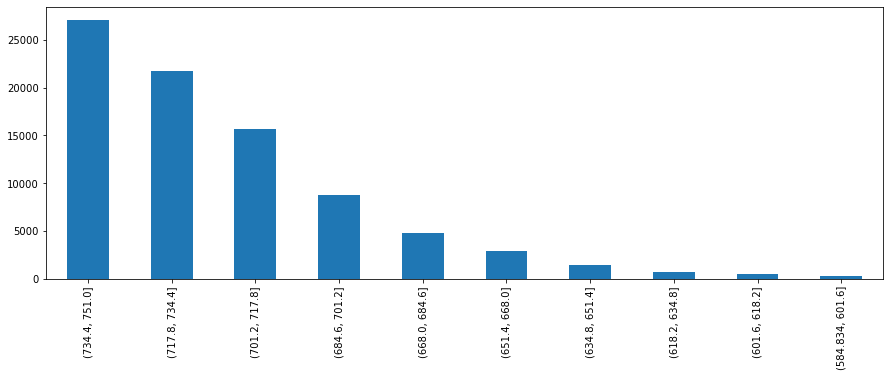

In [19]:
df['Credit Score Range'].value_counts().plot(kind='bar',figsize=(15,5))

In [20]:
# Normalize continuous columns
numeric = df.select_dtypes('number')
transformer = preprocessing.MinMaxScaler()
numeric_normalized = transformer.fit_transform(numeric.values)
df[numeric.columns] = numeric_normalized

In [ ]:
# View final dataframe after processing
df

In [ ]:
# Write processed dataframe to csv file called 'credit.csv'
df.to_csv('./datasets/credit.csv', index=False)